# Hyperparameter Optimization for DenseNet201 pre-trained model

## Imports and common parameters

In [80]:
sys.path.append("..") # Adds higher directory to python modules path.
import tensorflow as tf
import platform
from tensorflow.python.client import device_lib
import tensorflow.keras
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
from visuals import *
from data.data_loader import *
from collections import Counter
from visuals import *
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from visuals import plot_confusion_matrix
from tensorflow.keras import utils
from keras_numpy_backend import categorical_crossentropy
from helpers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_folder = '../data/isic2019/sampled_unbalanced_5000'

model_folder = 'models'
history_folder = 'history'
pred_result_folder_test = 'test_predict_results'

models_info = read_models_info(history_folder, pred_result_folder_test)

workers = os.cpu_count()

# How to handle SVG fonts
plt.rcParams['svg.fonttype'] = 'none'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Training Data

Number of known categories: 8
['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'] 

Number of unknown categories: 1
UNK 

Category to Index:
{'MEL': 0, 'NV': 1, 'BCC': 2, 'AK': 3, 'BKL': 4, 'DF': 5, 'VASC': 6, 'SCC': 7, 'UNK': 8} 

Training data has 5000 samples.
'MEL':	892	(17.84%)
'NV':	2541	(50.82%)
'BCC':	655	(13.10%)
'AK':	171	(3.42%)
'BKL':	517	(10.34%)
'DF':	47	(0.94%)
'VASC':	49	(0.98%)
'SCC':	128	(2.56%)
'UNK':	0	(0.00%)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,path,category
0,ISIC_0063450,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/sampled_unbalanced_5000/ISIC_...,0
1,ISIC_0060797,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,../data/isic2019/sampled_unbalanced_5000/ISIC_...,4
2,ISIC_0060141,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/sampled_unbalanced_5000/ISIC_...,1
3,ISIC_0024399,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/sampled_unbalanced_5000/ISIC_...,1
4,ISIC_0027153,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/sampled_unbalanced_5000/ISIC_...,1


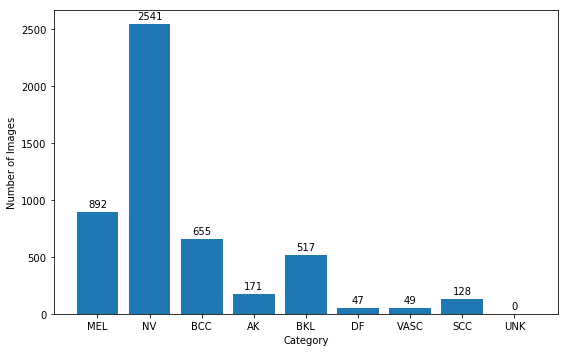

In [2]:
training_image_folder = os.path.join(data_folder, 'ISIC_2019_Training_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Training_GroundTruth.csv')

df_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(training_image_folder, ground_truth_file)
known_category_num = len(known_category_names)
print("Number of known categories: {}".format(known_category_num))
print(known_category_names, '\n')
unknown_category_num = 1
print("Number of unknown categories: {}".format(unknown_category_num))
print(unknown_category_name, '\n')
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

# mapping from category to index
print('Category to Index:')
category_to_index = dict((c, i) for i, c in enumerate(all_category_names))
print(category_to_index, '\n')

count_per_category = Counter(df_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Training data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
# plt.bar(count_per_category.keys(), count_per_category.values())
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()

df_ground_truth.head()

### Shuffle and Split Training Data into Training  and Validation Sets

In [3]:
df_train, df_val = train_validation_split(df_ground_truth)

# Training Set
sample_count_train = df_train.shape[0]
print("Training set has {} samples.".format(sample_count_train))
count_per_category_train = Counter(df_train['category'])
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category_train[i], count_per_category_train[i]*100/sample_count_train))

# Validation Set
sample_count_val = df_val.shape[0]
print("\nValidation set has {} samples.".format(sample_count_val))

Training set has 4000 samples.
'MEL':	714	(17.85%)
'NV':	2033	(50.83%)
'BCC':	524	(13.10%)
'AK':	137	(3.42%)
'BKL':	414	(10.35%)
'DF':	37	(0.93%)
'VASC':	39	(0.97%)
'SCC':	102	(2.55%)
'UNK':	0	(0.00%)

Validation set has 1000 samples.


### Class Weights based on the Traning Set

Class Weights (without UNK):
'MEL':	0.700280
'NV':	0.245942
'BCC':	0.954198
'AK':	3.649635
'BKL':	1.207729
'DF':	13.513514
'VASC':	12.820513
'SCC':	4.901961


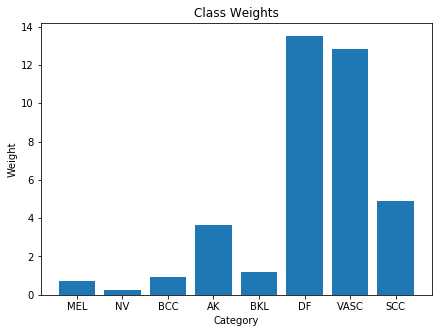

In [5]:
class_weight_dict = compute_class_weight_dict(df_train)
print('Class Weights (without UNK):')
for i, c in enumerate(known_category_names):
    print("'%s':\t%f" % (c, class_weight_dict[i]))

# Create a bar chart
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
ax.set_title('Class Weights')
ax.set(xlabel='Category', ylabel='Weight')
plt.bar(known_category_names, [class_weight_dict[i] for i in range(known_category_num)]);

## DenseNet201 hyperparameter optimization

### Batch size comparisson

(4.0, 8.0, 16.0, 32.0)
(79.01, 87.47, 91.59, 93.83)
(4.0, 8.0, 16.0, 32.0)
(80.35, 89.35, 93.8, 95.4)


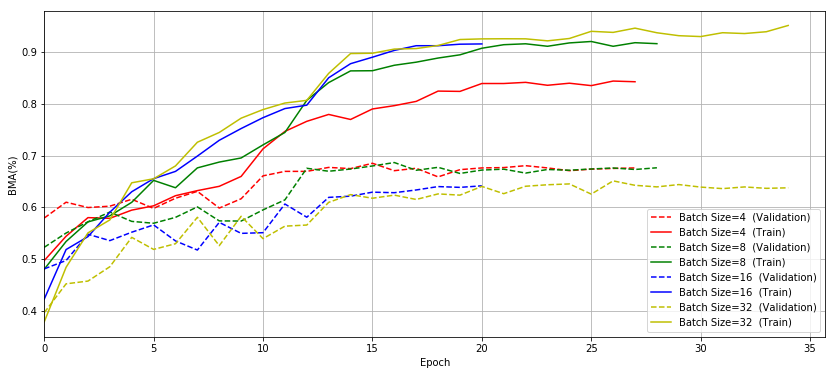

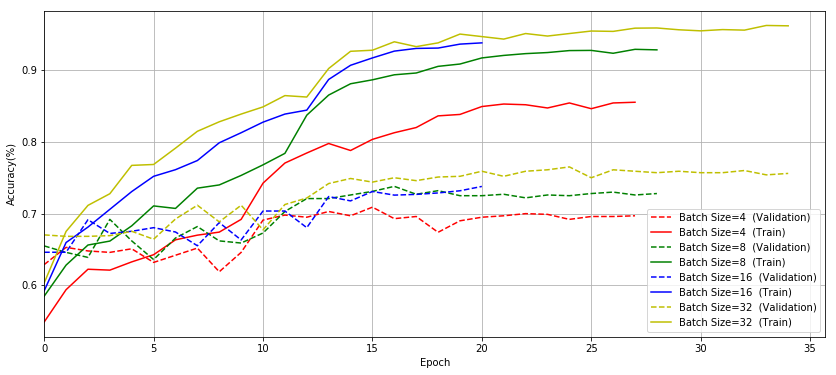

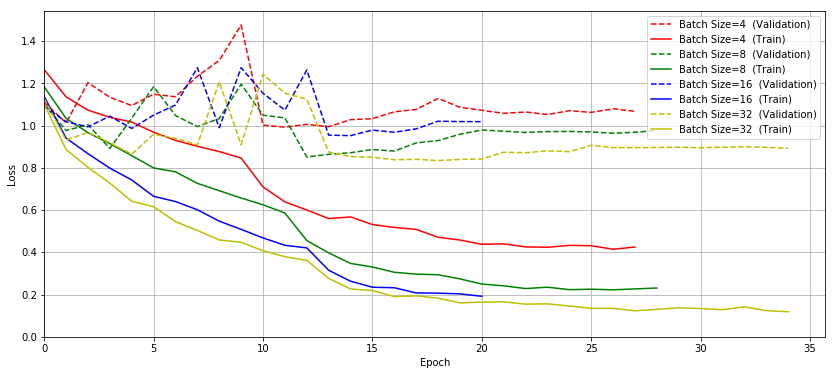

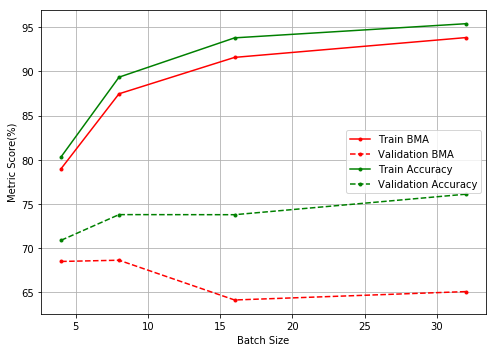

In [61]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "dropout": None, 
    "lambda": None,
    "felr": 0.0001, 
    "ftlr": 0.0001, 
    "feepochs": 0,
    "dggroup": "11",
    
}

fig1 = plot_hyperparameter_over_epochs(
    models_info,
    "balanced_accuracy",
    "BMA(%)",
    hyperparameter_compared="batch",
    hyperparameter_compared_label="Batch Size",
    constant_parameters=constant_params,
    feature_extract_epochs=None,
)

fig2 = plot_hyperparameter_over_epochs(
    models_info,
    "accuracy",
    "Accuracy(%)",
    hyperparameter_compared="batch",
    hyperparameter_compared_label="Batch Size",
    constant_parameters=constant_params,
    feature_extract_epochs=None,
)

fig3 = plot_hyperparameter_over_epochs(
    models_info,
    "loss",
    "Loss",
    hyperparameter_compared="batch",
    hyperparameter_compared_label="Batch Size",
    constant_parameters=constant_params,
    feature_extract_epochs=None,
    y_min=0,
)

fig4 = plot_hyperparameter_comparisson(
    filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ),
    "batch",
    parameter_label="Batch Size",
    test_metric=[],
)

fig1.savefig(os.path.join("densenet201_batch_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
fig4.savefig(os.path.join("densenet201_batch_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

### Feature extract epochs comparisson

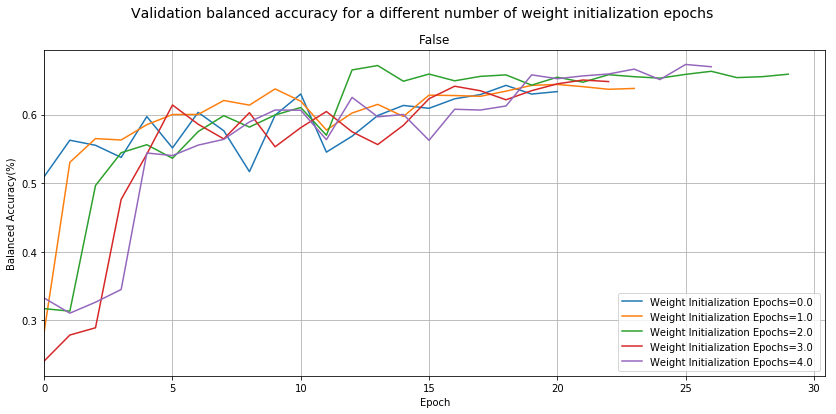

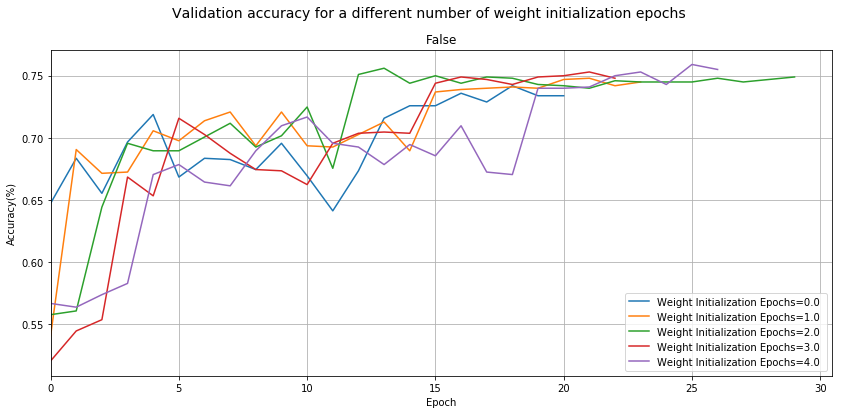

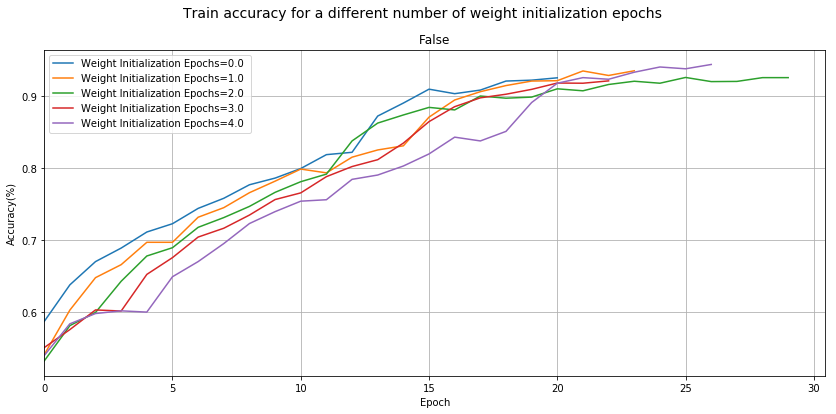

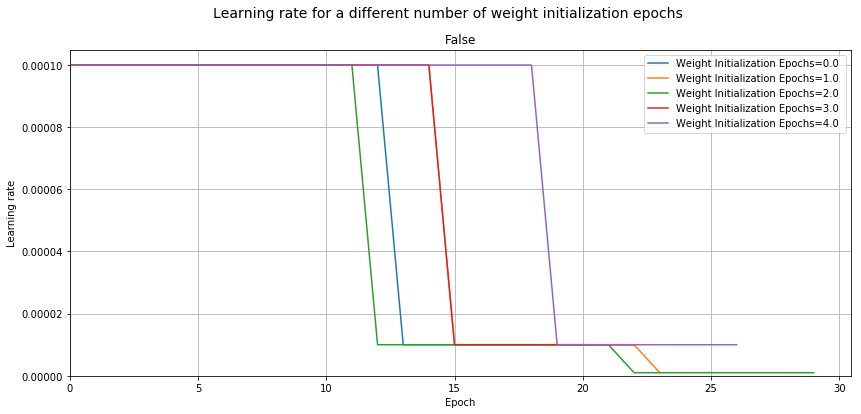

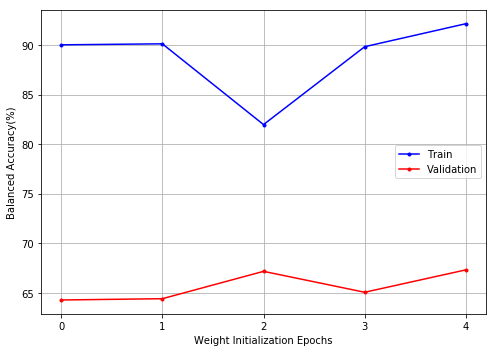

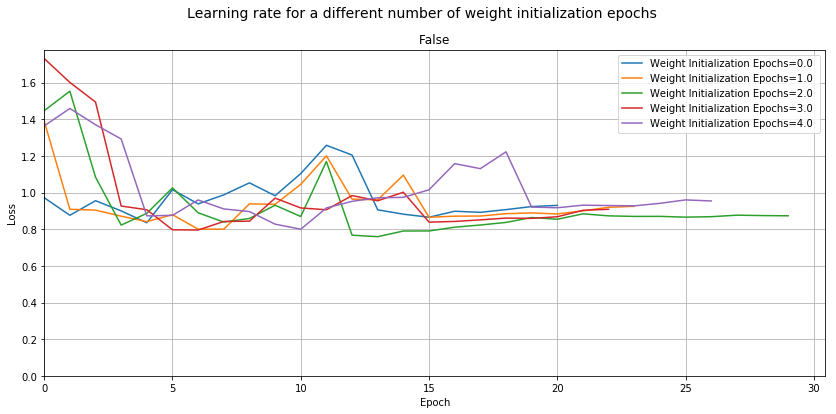

In [80]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "dropout": None, 
    "lambda": None,
    "felr": 0.0001, 
    "ftlr": 0.0001, 
    "batch": 16,
    "dggroup": 11,
    "feepochs": ["0", "1", "2", "3", "4"]
}

fig1 = plot_hyperparameter_over_epochs(
    models_info,
    "val_balanced_accuracy",
    "Balanced Accuracy(%)",
    hyperparameter_compared="feepochs",
    hyperparameter_compared_label="Weight Initialization Epochs",
    constant_parameters=constant_params,
    title="Validation balanced accuracy for a different number of weight initialization epochs",
    feature_extract_epochs=None,
)

fig2 = plot_hyperparameter_over_epochs(
    models_info,
    "val_accuracy",
    "Accuracy(%)",
    hyperparameter_compared="feepochs",
    hyperparameter_compared_label="Weight Initialization Epochs",
    constant_parameters=constant_params,
    title="Validation accuracy for a different number of weight initialization epochs",
    feature_extract_epochs=None,
)

fig3 = plot_hyperparameter_over_epochs(
    models_info,
    "accuracy",
    "Accuracy(%)",
    hyperparameter_compared="feepochs",
    hyperparameter_compared_label="Weight Initialization Epochs",
    constant_parameters=constant_params,
    title="Train accuracy for a different number of weight initialization epochs",
    feature_extract_epochs=None,
)

fig4 = plot_hyperparameter_over_epochs(
    models_info,
    "lr",
    "Learning rate",
    hyperparameter_compared="feepochs",
    hyperparameter_compared_label="Weight Initialization Epochs",
    constant_parameters=constant_params,
    title="Learning rate for a different number of weight initialization epochs",
    feature_extract_epochs=None,
    y_min=0,
    y_scale="linear"
)

fig5 = plot_hyperparameter_comparisson(
    filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ),
    "feepochs",
    parameter_label="Weight Initialization Epochs",
    test_metric=balanced_accuracy_score,
    x_int_ticks=True
)

fig6 = plot_hyperparameter_over_epochs(
    models_info,
    "val_loss",
    "Loss",
    hyperparameter_compared="feepochs",
    hyperparameter_compared_label="Weight Initialization Epochs",
    constant_parameters=constant_params,
    title="Learning rate for a different number of weight initialization epochs",
    feature_extract_epochs=None,
    y_min=0,
    y_scale="linear"
)

fig1.savefig(os.path.join("densenet201_wiepochs_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
fig5.savefig(os.path.join("densenet201_wiepochs_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

(0.0, 2.0, 4.0, 6.0)
(91.59, 88.09, 92.15, 91.32)
(0.0, 2.0, 4.0, 6.0)
(93.8, 91.25, 93.75, 93.3)


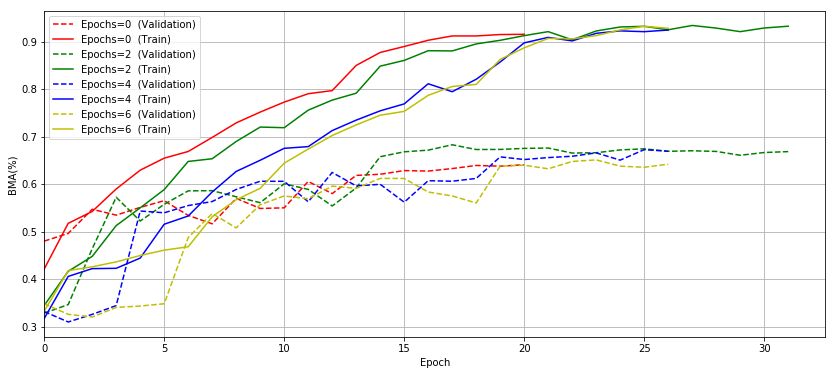

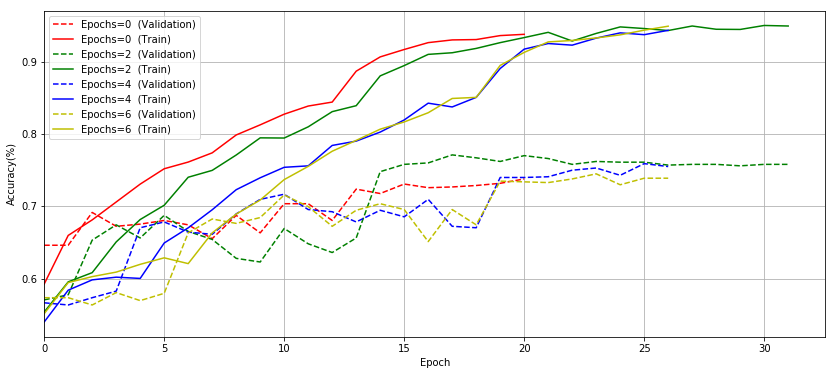

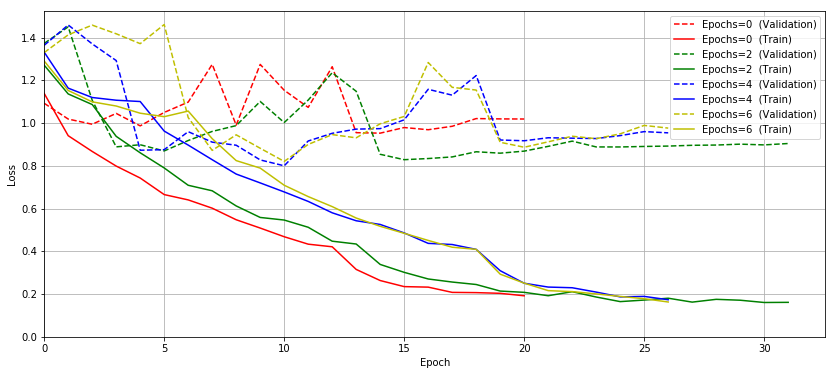

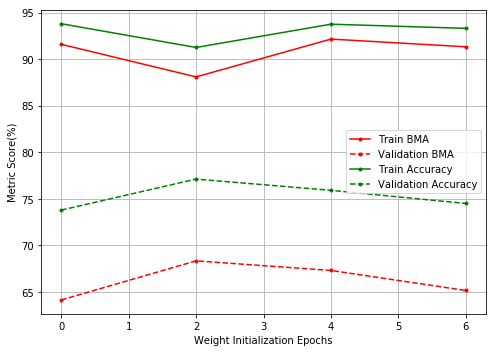

In [60]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "dropout": None, 
    "lambda": None,
    "felr": 0.0001, 
    "ftlr": 0.0001, 
    "batch": 16,
    "dggroup": 11,
    "feepochs": ["0", "2", "4", "6"]
}

fig1 = plot_hyperparameter_over_epochs(
    models_info,
    "balanced_accuracy",
    "BMA(%)",
    hyperparameter_compared="feepochs",
    hyperparameter_compared_label="Epochs",
    constant_parameters=constant_params,
    feature_extract_epochs=None,
)

fig2 = plot_hyperparameter_over_epochs(
    models_info,
    "accuracy",
    "Accuracy(%)",
    hyperparameter_compared="feepochs",
    hyperparameter_compared_label="Epochs",
    constant_parameters=constant_params,
    feature_extract_epochs=None,
)

fig3 = plot_hyperparameter_over_epochs(
    models_info,
    "loss",
    "Loss",
    hyperparameter_compared="feepochs",
    hyperparameter_compared_label="Epochs",
    constant_parameters=constant_params,
    feature_extract_epochs=None,
    y_min=0,
    y_scale="linear"
)

# fig4 = plot_hyperparameter_over_epochs(
#     models_info,
#     "lr",
#     "Learning rate",
#     hyperparameter_compared="feepochs",
#     hyperparameter_compared_label="Weight Initialization Epochs",
#     constant_parameters=constant_params,
#     title="Learning rate for a different number of weight initialization epochs",
#     feature_extract_epochs=None,
#     y_min=0,
#     y_scale="linear"
# )

fig5 = plot_hyperparameter_comparisson(
    filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ),
    "feepochs",
    parameter_label="Weight Initialization Epochs",
    test_metric=balanced_accuracy_score,
    x_int_ticks=True
)


fig1.savefig(os.path.join("densenet201_wiepochs_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
fig5.savefig(os.path.join("densenet201_wiepochs_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

### Learning rate comparisson 

#### Weight Initialization Learning Rate

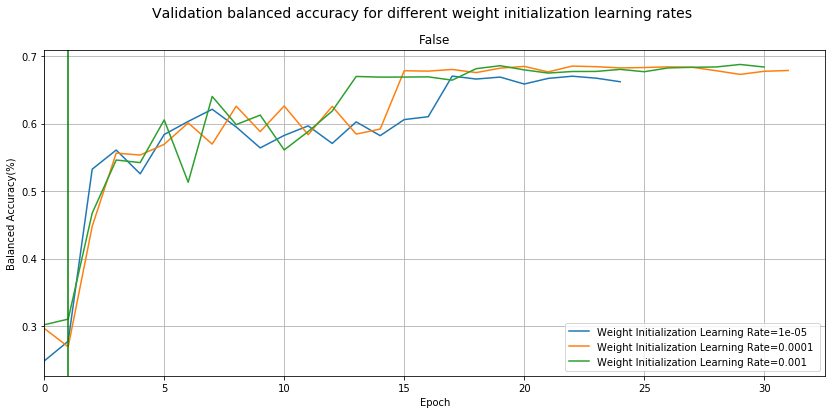

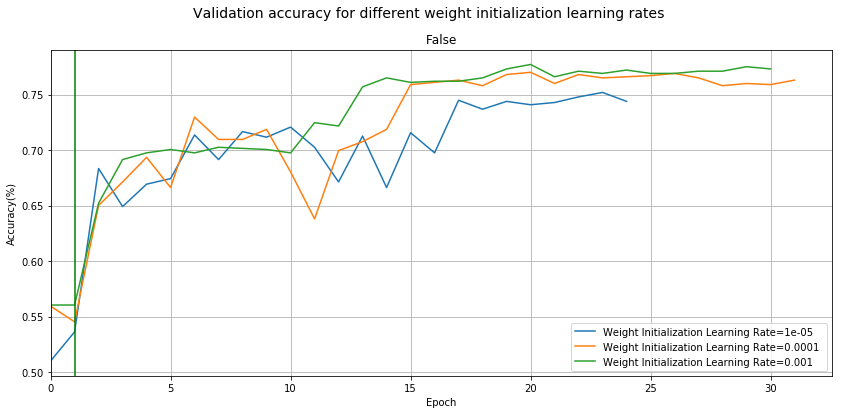

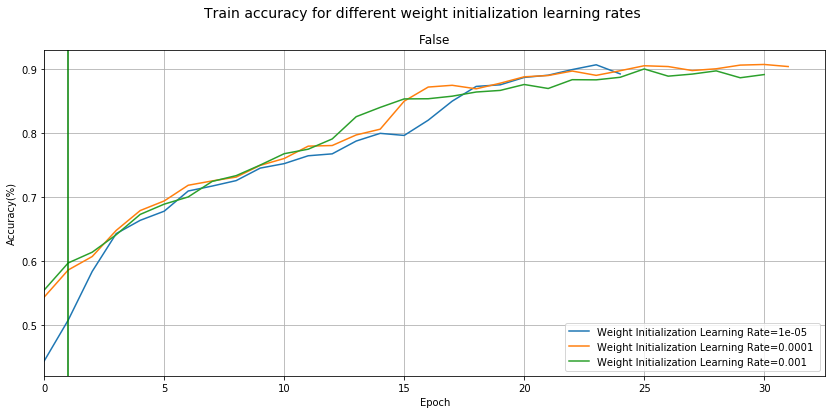

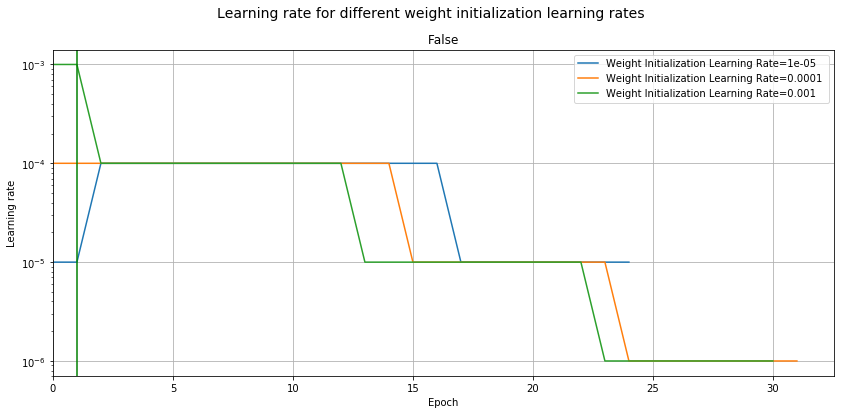

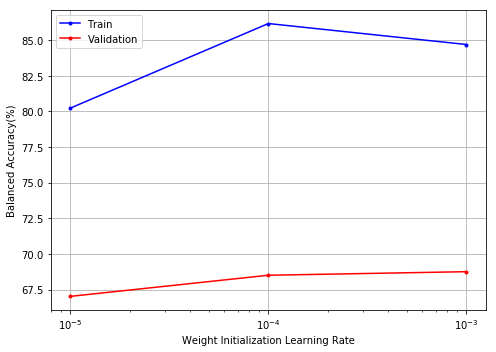

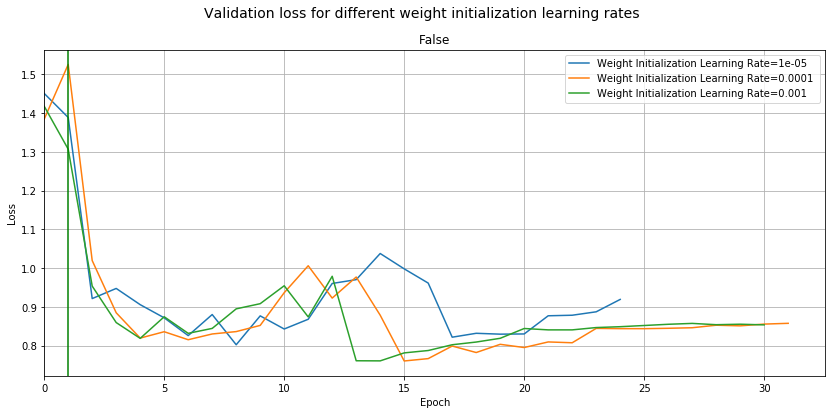

In [10]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "dropout": None, 
    "lambda": None,
    "feepochs": 2, 
    "ftlr": 0.0001, 
    "batch": 16
}

fig1 = plot_hyperparameter_over_epochs(
    models_info,
    "val_balanced_accuracy",
    "Balanced Accuracy(%)",
    hyperparameter_compared="felr",
    hyperparameter_compared_label="Weight Initialization Learning Rate",
    constant_parameters=constant_params,
    title="Validation balanced accuracy for different weight initialization learning rates",
    feature_extract_epochs=2,
)

fig2 = plot_hyperparameter_over_epochs(
    models_info,
    "val_accuracy",
    "Accuracy(%)",
    hyperparameter_compared="felr",
    hyperparameter_compared_label="Weight Initialization Learning Rate",
    constant_parameters=constant_params,
    title="Validation accuracy for different weight initialization learning rates",
    feature_extract_epochs=2,
)

fig3 = plot_hyperparameter_over_epochs(
    models_info,
    "accuracy",
    "Accuracy(%)",
    hyperparameter_compared="felr",
    hyperparameter_compared_label="Weight Initialization Learning Rate",
    constant_parameters=constant_params,
    title="Train accuracy for different weight initialization learning rates",
    feature_extract_epochs=2,
)

fig4 = plot_hyperparameter_over_epochs(
    models_info,
    "lr",
    "Learning rate",
    hyperparameter_compared="felr",
    hyperparameter_compared_label="Weight Initialization Learning Rate",
    constant_parameters=constant_params,
    title="Learning rate for different weight initialization learning rates",
    feature_extract_epochs=2,
    y_scale="log"
)


fig5 = plot_hyperparameter_comparisson(
    filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ),
    "felr",
    parameter_label="Weight Initialization Learning Rate",
    x_scale="log"
)

fig6 = plot_hyperparameter_over_epochs(
    models_info,
    "val_loss",
    "Loss",
    hyperparameter_compared="felr",
    hyperparameter_compared_label="Weight Initialization Learning Rate",
    constant_parameters=constant_params,
    title="Validation loss for different weight initialization learning rates",
    feature_extract_epochs=2,
)

fig1.savefig(os.path.join("densenet201_wilr_bma_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
fig4.savefig(os.path.join("densenet201_wilr_lr_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
fig5.savefig(os.path.join("densenet201_wilr_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

(1e-05, 0.0001, 0.001)
(88.94, 88.09, 90.63)
(1e-05, 0.0001, 0.001)
(91.32, 91.25, 92.52)


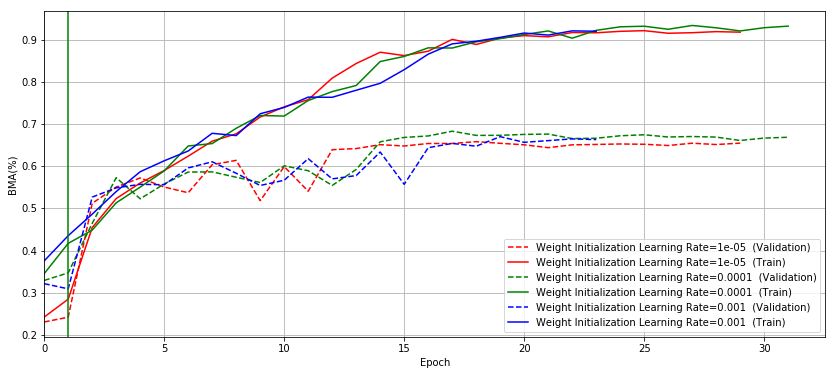

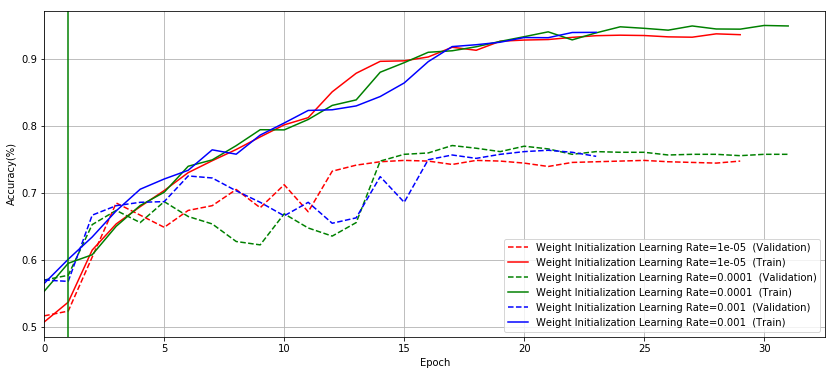

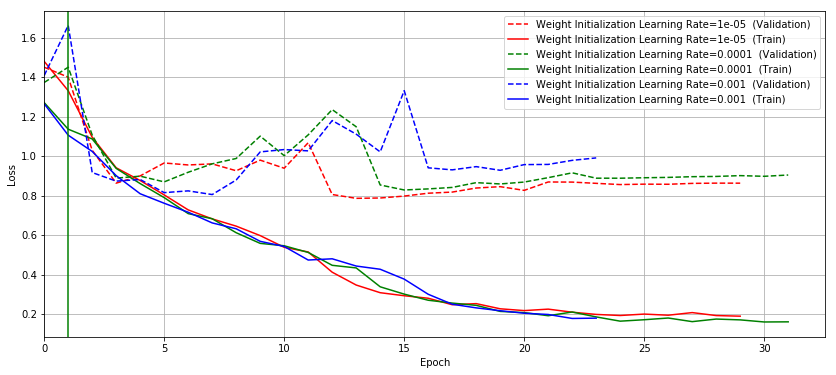

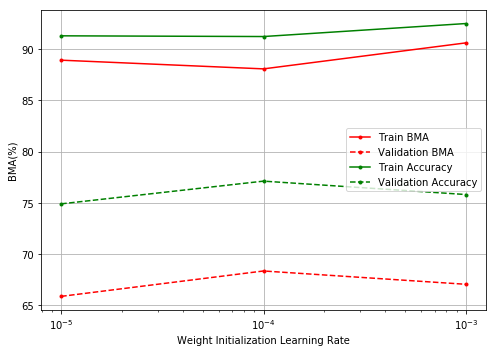

In [38]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "dropout": None, 
    "lambda": None,
    "feepochs": 2, 
    "ftlr": 0.0001, 
    "batch": 16,
    "dggroup": "11"
}

fig1 = plot_hyperparameter_over_epochs(
    models_info,
    "balanced_accuracy",
    "BMA(%)",
    hyperparameter_compared="felr",
    hyperparameter_compared_label="Weight Initialization Learning Rate",
    constant_parameters=constant_params,
    feature_extract_epochs=2,
)

fig2 = plot_hyperparameter_over_epochs(
    models_info,
    "accuracy",
    "Accuracy(%)",
    hyperparameter_compared="felr",
    hyperparameter_compared_label="Weight Initialization Learning Rate",
    constant_parameters=constant_params,
    feature_extract_epochs=2,
)

fig3 = plot_hyperparameter_over_epochs(
    models_info,
    "loss",
    "Loss",
    hyperparameter_compared="felr",
    hyperparameter_compared_label="Weight Initialization Learning Rate",
    constant_parameters=constant_params,
    feature_extract_epochs=2,
)

# fig4 = plot_hyperparameter_over_epochs(
#     models_info,
#     "lr",
#     "Learning rate",
#     hyperparameter_compared="felr",
#     hyperparameter_compared_label="Weight Initialization Learning Rate",
#     constant_parameters=constant_params,
#     title="Learning rate for different weight initialization learning rates",
#     feature_extract_epochs=2,
#     y_scale="log"
# )


fig5 = plot_hyperparameter_comparisson(
    filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ),
    "felr",
    parameter_label="Weight Initialization Learning Rate",
    x_scale="log"
)

# fig1.savefig(os.path.join("densenet201_wilr_bma_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
# fig4.savefig(os.path.join("densenet201_wilr_lr_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
# fig5.savefig(os.path.join("densenet201_wilr_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

#### Fine tuning learning rate

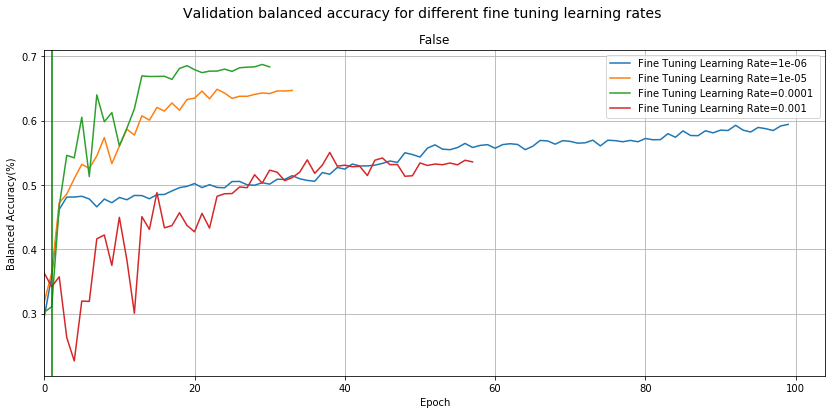

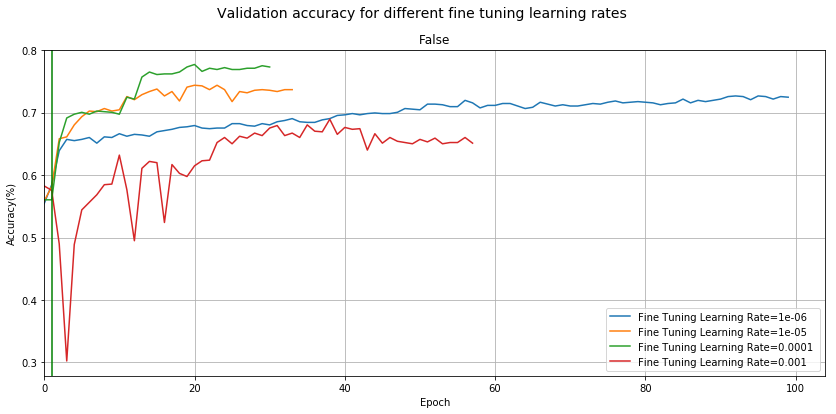

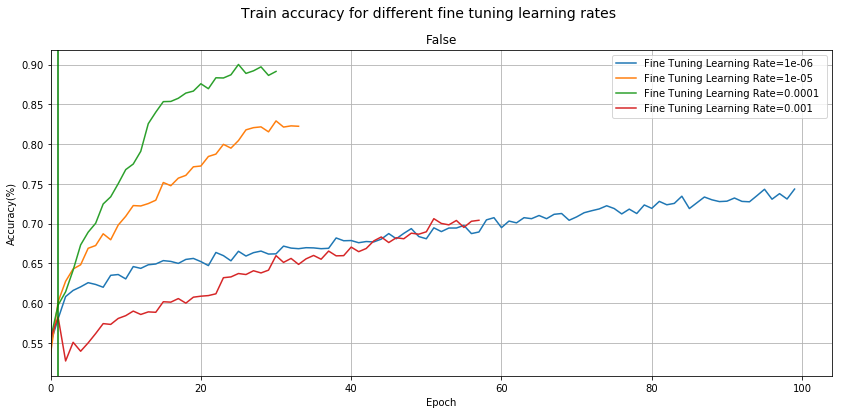

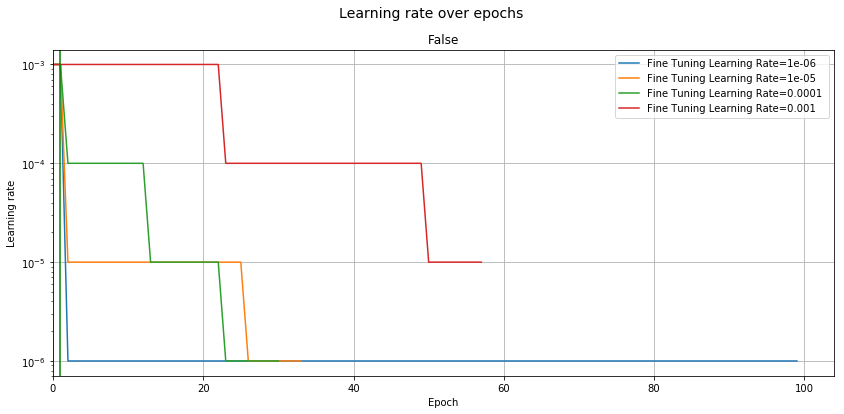

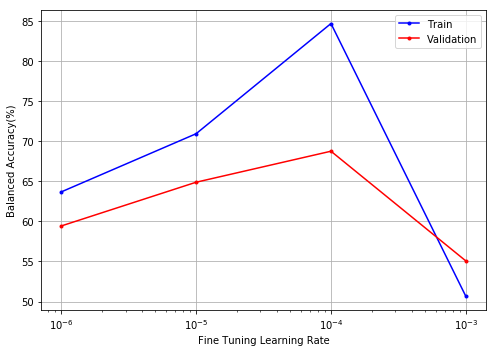

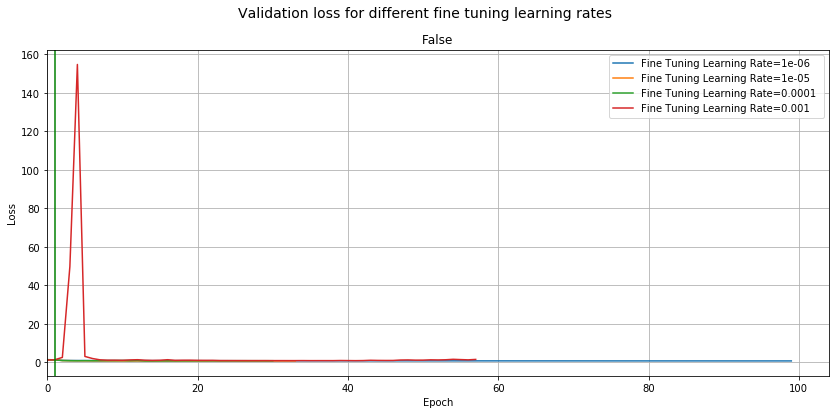

In [11]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "dropout": None, 
    "lambda": None,
    "feepochs": 2, 
    "felr": 0.001, 
    "batch": 16
}

fig1 = plot_hyperparameter_over_epochs(
    models_info,
    "val_balanced_accuracy",
    "Balanced Accuracy(%)",
    hyperparameter_compared="ftlr",
    hyperparameter_compared_label="Fine Tuning Learning Rate",
    constant_parameters=constant_params,
    title="Validation balanced accuracy for different fine tuning learning rates",
    feature_extract_epochs=2,
)

fig2 = plot_hyperparameter_over_epochs(
    models_info,
    "val_accuracy",
    "Accuracy(%)",
    hyperparameter_compared="ftlr",
    hyperparameter_compared_label="Fine Tuning Learning Rate",
    constant_parameters=constant_params,
    title="Validation accuracy for different fine tuning learning rates",
    feature_extract_epochs=2,
)

fig3 = plot_hyperparameter_over_epochs(
    models_info,
    "accuracy",
    "Accuracy(%)",
    hyperparameter_compared="ftlr",
    hyperparameter_compared_label="Fine Tuning Learning Rate",
    constant_parameters=constant_params,
    title="Train accuracy for different fine tuning learning rates",
    feature_extract_epochs=2,
)

fig4 = plot_hyperparameter_over_epochs(
    models_info,
    "lr",
    "Learning rate",
    hyperparameter_compared="ftlr",
    hyperparameter_compared_label="Fine Tuning Learning Rate",
    constant_parameters=constant_params,
    title="Learning rate over epochs",
    feature_extract_epochs=2,
    y_scale="log"
)

fig5 = plot_hyperparameter_comparisson(
    filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ),
    "ftlr",
    parameter_label="Fine Tuning Learning Rate",
    x_scale="log"
)

fig6 = plot_hyperparameter_over_epochs(
    models_info,
    "val_loss",
    "Loss",
    hyperparameter_compared="ftlr",
    hyperparameter_compared_label="Fine Tuning Learning Rate",
    constant_parameters=constant_params,
    title="Validation loss for different fine tuning learning rates",
    feature_extract_epochs=2,
)


fig1.savefig(os.path.join("densenet201_ftlr_bma_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
fig4.savefig(os.path.join("densenet201_ftlr_lr_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
fig5.savefig(os.path.join("densenet201_ftlr_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

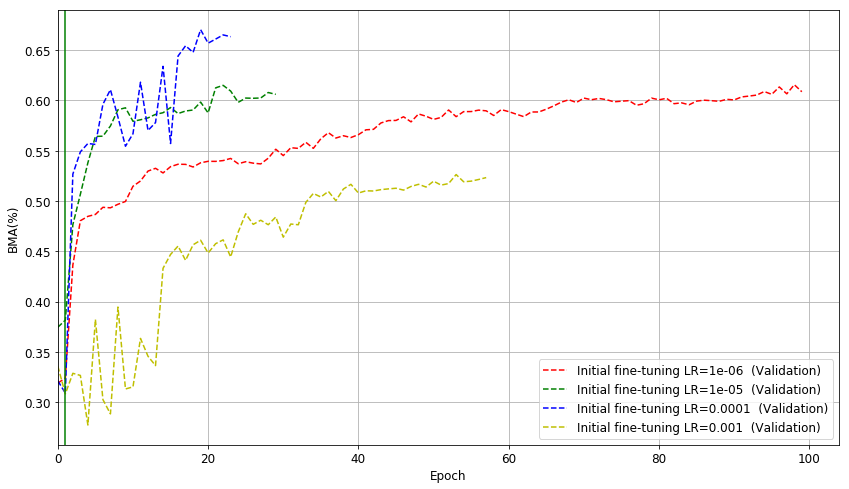

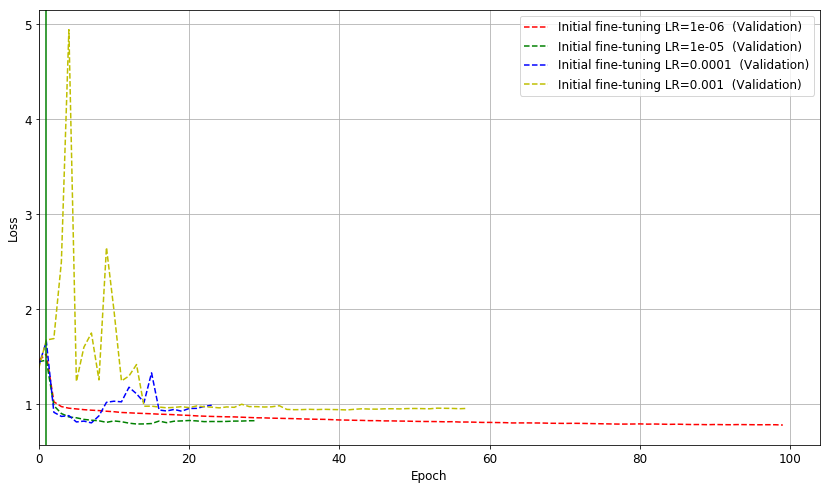

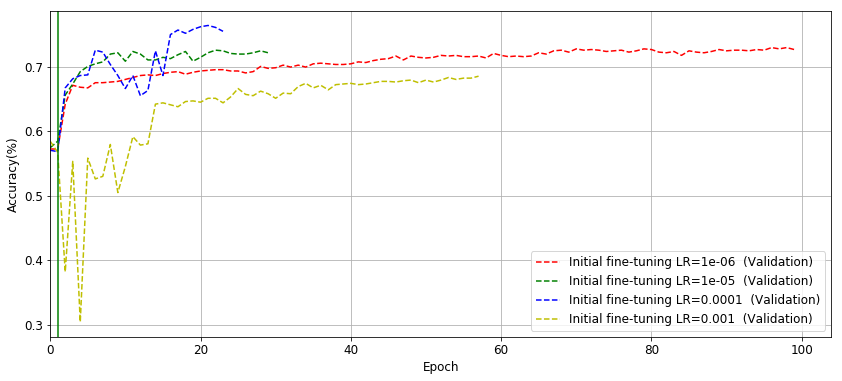

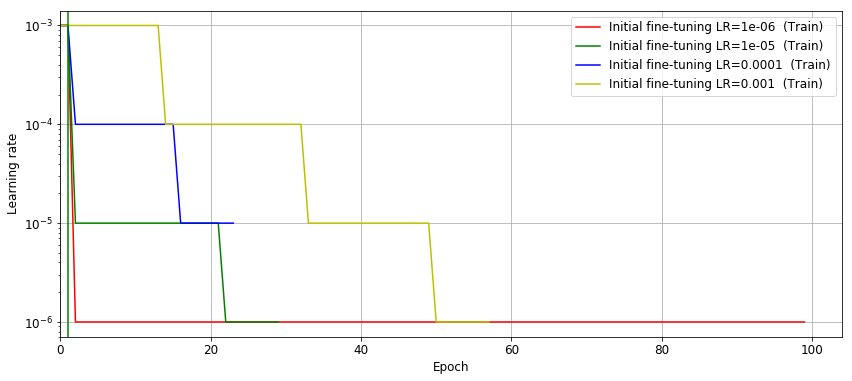

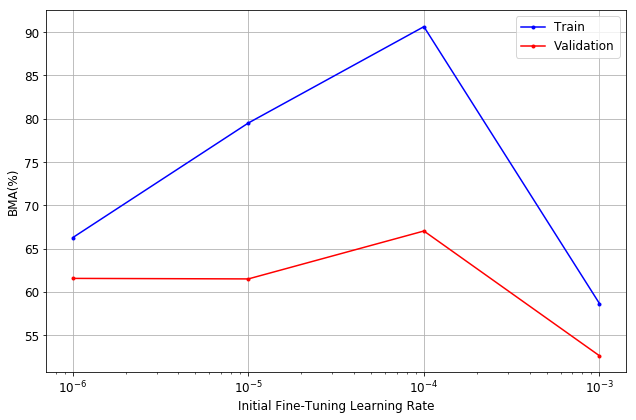

In [53]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "dropout": None, 
    "lambda": None,
    "feepochs": 2, 
    "felr": 0.001, 
    "batch": 16,
    "dggroup": 11
}

import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig1 = plot_hyperparameter_over_epochs(
    models_info,
    "balanced_accuracy",
    "BMA(%)",
    hyperparameter_compared="ftlr",
    hyperparameter_compared_label="Initial fine-tuning LR",
    constant_parameters=constant_params,
    feature_extract_epochs=2,
    figsize=(14, 8)
)

fig2 = plot_hyperparameter_over_epochs(
    models_info,
    "loss",
    "Loss",
    hyperparameter_compared="ftlr",
    hyperparameter_compared_label="Initial fine-tuning LR",
    constant_parameters=constant_params,
    feature_extract_epochs=2,
    figsize=(14, 8)
)

fig3 = plot_hyperparameter_over_epochs(
    models_info,
    "accuracy",
    "Accuracy(%)",
    hyperparameter_compared="ftlr",
    hyperparameter_compared_label="Initial fine-tuning LR",
    constant_parameters=constant_params,
    feature_extract_epochs=2,
)

fig4 = plot_lr_over_epochs(
    models_info,
    "lr",
    "Learning rate",
    hyperparameter_compared="ftlr",
    hyperparameter_compared_label="Initial fine-tuning LR",
    constant_parameters=constant_params,
    feature_extract_epochs=2,
    y_scale="log"
)
fig2.savefig(os.path.join("densenet201_ftlr_val_loss_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

fig5 = plot_hyperparameter_comparisson(
    filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ),
    "ftlr",
    parameter_label="Initial Fine-Tuning Learning Rate",
    metric_label="BMA(%)",
    train_metric=["balanced_accuracy"],
    val_metric=["val_balanced_accuracy"],
    x_scale="log",
    figsize=(9, 6),
    train_label=["Train"],
    val_label=["Validation"]
)

# fig1.savefig(os.path.join("densenet201_ftlr_bma_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
# fig4.savefig(os.path.join("densenet201_ftlr_lr_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
# fig2.savefig(os.path.join("densenet201_ftlr_val_loss_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
fig5.savefig(os.path.join("densenet201_ftlr_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)


### Dropout comparisson 

[{'model': 'DenseNet201', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '2', 'felr': '0.001000', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': '0.200000', 'batch': '16'}, 'log': '../history/DenseNet201/balanced_0-samples_5000-feepochs_2-felr_0.001000-ftlr_0.000100-lambda_None-dropout_0.200000-batch_16/0/training.csv', 'pred_test': None}, {'model': 'DenseNet201', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '2', 'felr': '0.001000', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': '0.300000', 'batch': '16'}, 'log': '../history/DenseNet201/balanced_0-samples_5000-feepochs_2-felr_0.001000-ftlr_0.000100-lambda_None-dropout_0.300000-batch_16/0/training.csv', 'pred_test': None}, {'model': 'DenseNet201', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '2', 'felr': '0.001000', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': '0.400000', 'batch': '16'}, 'log': '../history/DenseNet201/balanced_0-samples_5000-feepochs_2-felr_0.001

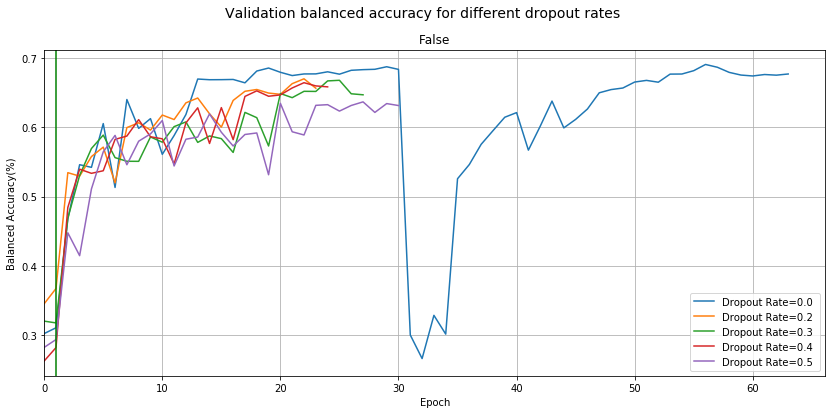

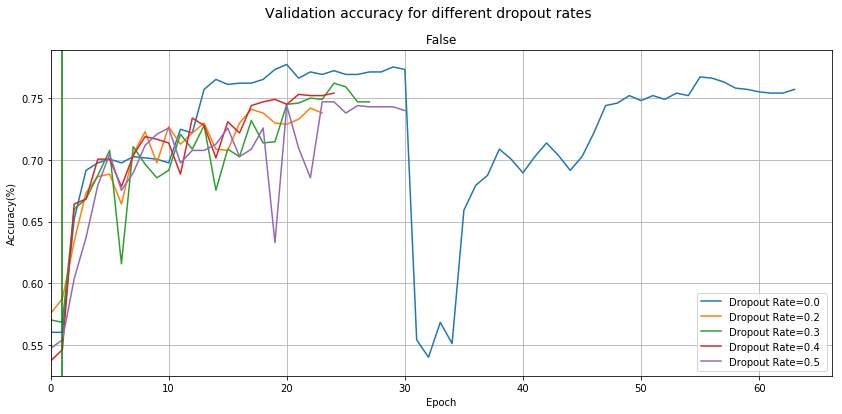

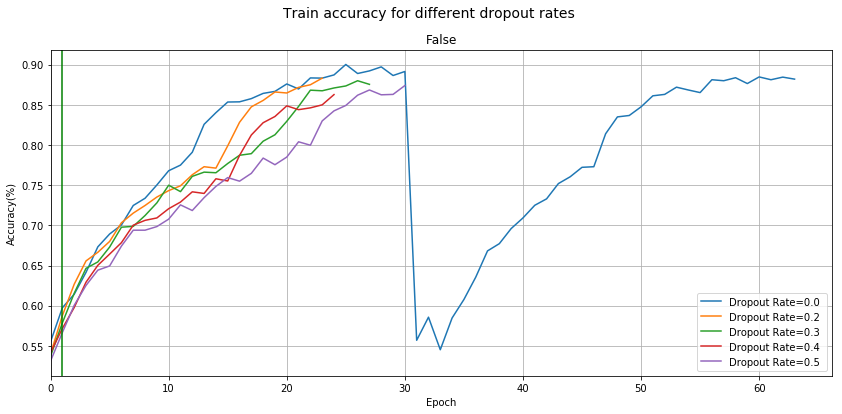

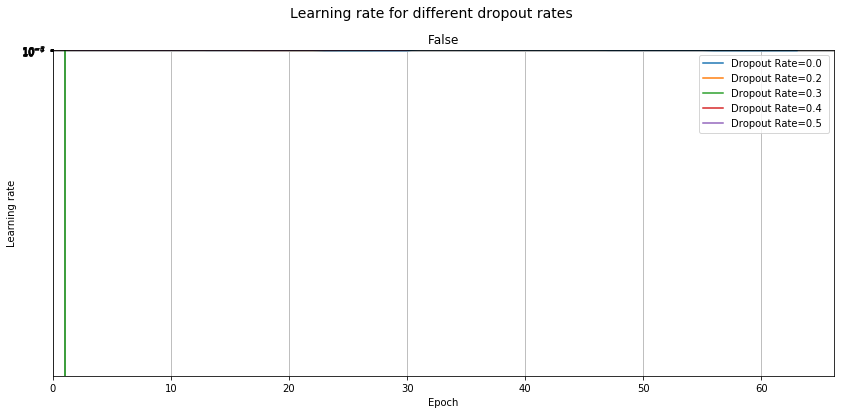

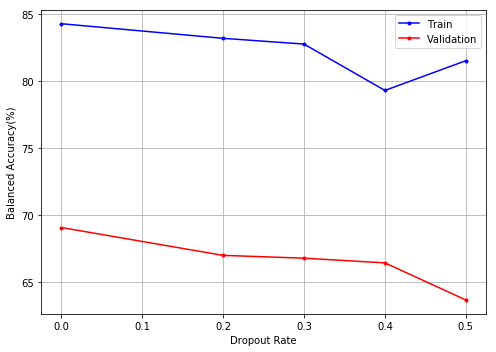

In [111]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "lambda": None,
    "feepochs": 2, 
    "felr": 0.001, 
    "ftlr": 0.0001, 
    "batch": 16,
    "dggroup": None,
}

fig1 = plot_hyperparameter_over_epochs(
    models_info,
    "val_balanced_accuracy",
    "Balanced Accuracy(%)",
    hyperparameter_compared="dropout",
    hyperparameter_compared_label="Dropout Rate",
    constant_parameters=constant_params,
    title="Validation balanced accuracy for different dropout rates",
    feature_extract_epochs=2,
)

fig2 = plot_hyperparameter_over_epochs(
    models_info,
    "val_accuracy",
    "Accuracy(%)",
    hyperparameter_compared="dropout",
    hyperparameter_compared_label="Dropout Rate",
    constant_parameters=constant_params,
    title="Validation accuracy for different dropout rates",
    feature_extract_epochs=2,
)

fig3 = plot_hyperparameter_over_epochs(
    models_info,
    "accuracy",
    "Accuracy(%)",
    hyperparameter_compared="dropout",
    hyperparameter_compared_label="Dropout Rate",
    constant_parameters=constant_params,
    title="Train accuracy for different dropout rates",
    feature_extract_epochs=2,
)

fig4 = plot_hyperparameter_over_epochs(
    models_info,
    "lr",
    "Learning rate",
    hyperparameter_compared="dropout",
    hyperparameter_compared_label="Dropout Rate",
    constant_parameters=constant_params,
    title="Learning rate for different dropout rates",
    feature_extract_epochs=2,
    y_min=0,
    y_scale="log"
)

print(filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ))

fig5 = plot_hyperparameter_comparisson(
    filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ),
    "dropout",
    parameter_label="Dropout Rate",
)

fig5.savefig(os.path.join("densenet201_dropout_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

(0.0, 0.1, 0.2, 0.3, 0.4, 0.5)
(90.63, 91.12, 90.41, 89.75, 88.21, 89.53)
(0.0, 0.1, 0.2, 0.3, 0.4, 0.5)
(92.52, 93.15, 92.2, 92.22, 90.75, 91.42)


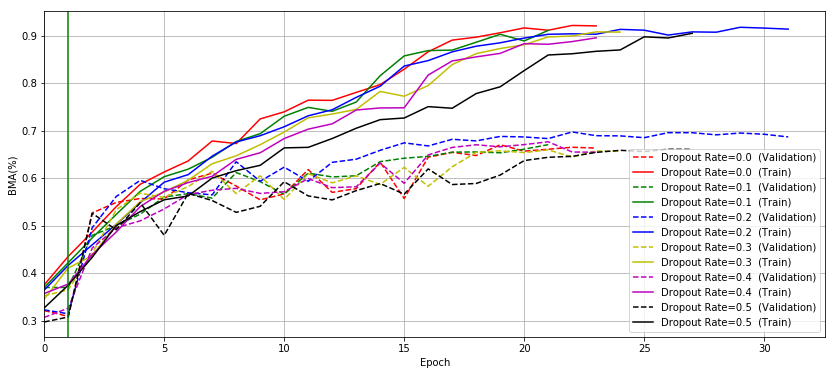

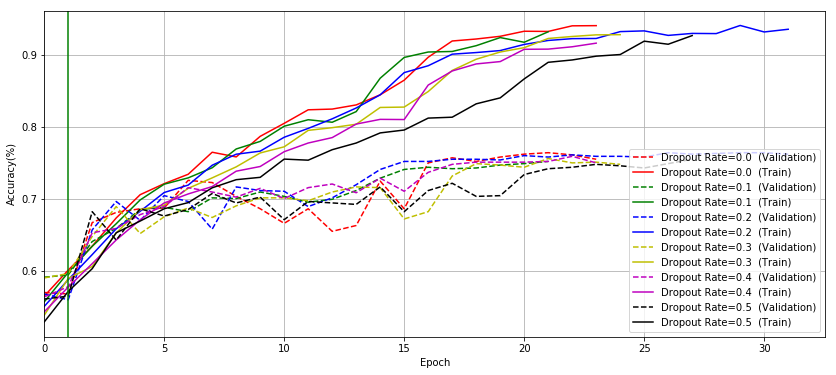

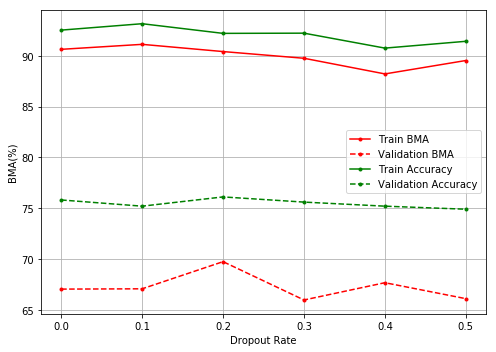

In [43]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "lambda": None,
    "feepochs": 2, 
    "felr": 0.001, 
    "ftlr": 0.0001, 
    "batch": 16,
    "dggroup": "11",
}

fig1 = plot_hyperparameter_over_epochs(
    models_info,
    "balanced_accuracy",
    "BMA(%)",
    hyperparameter_compared="dropout",
    hyperparameter_compared_label="Dropout Rate",
    constant_parameters=constant_params,
    feature_extract_epochs=2,
)

fig3 = plot_hyperparameter_over_epochs(
    models_info,
    "accuracy",
    "Accuracy(%)",
    hyperparameter_compared="dropout",
    hyperparameter_compared_label="Dropout Rate",
    constant_parameters=constant_params,
    feature_extract_epochs=2,
)

# fig4 = plot_hyperparameter_over_epochs(
#     models_info,
#     "lr",
#     "Learning rate",
#     hyperparameter_compared="dropout",
#     hyperparameter_compared_label="Dropout Rate",
#     constant_parameters=constant_params,
#     feature_extract_epochs=2,
#     y_min=0,
#     y_scale="log"
# )

fig5 = plot_hyperparameter_comparisson(
    filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ),
    "dropout",
    parameter_label="Dropout Rate",
)

[{'model': 'DenseNet201', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '2', 'ftepochs': '100', 'felr': '0.001000', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '16', 'dggroup': '11', 'patience': '2'}, 'log': '../history/DenseNet201/balanced_0-samples_5000-feepochs_2-ftepochs_100-felr_0.001000-ftlr_0.000100-lambda_None-dropout_None-batch_16-dggroup_11-patience_2/0/training.csv', 'pred_test_0': None, 'pred_test': None}, {'model': 'DenseNet201', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '2', 'ftepochs': '100', 'felr': '0.001000', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '16', 'dggroup': '11', 'patience': '4'}, 'log': '../history/DenseNet201/balanced_0-samples_5000-feepochs_2-ftepochs_100-felr_0.001000-ftlr_0.000100-lambda_None-dropout_None-batch_16-dggroup_11-patience_4/0/training.csv', 'pred_test_0': None, 'pred_test': None}, {'model': 'DenseNet201', 'hyperparameters': {'balanced': '0', 'sample

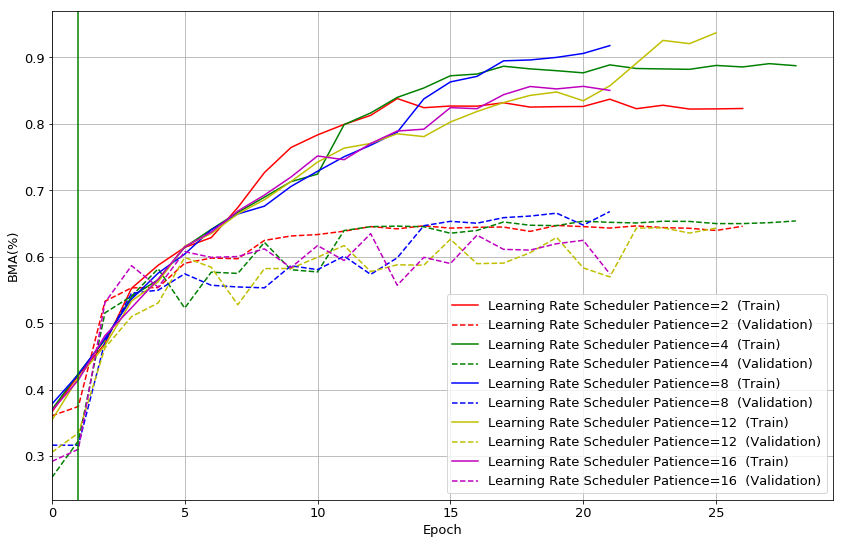

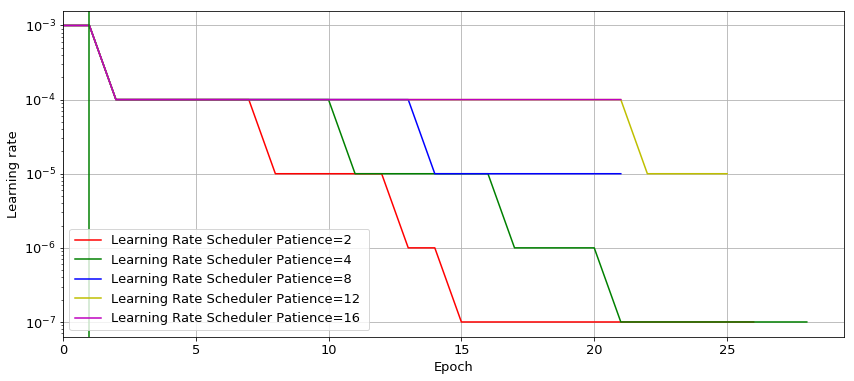

In [79]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "lambda": None,
    "dropout": None,
    "feepochs": 2, 
    "ftepochs": 100,
    "felr": 0.001, 
    "ftlr": 0.0001, 
    "batch": 16,
    "dggroup": "11",
    "patience": [2,4,8,12,16]
}

import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

fig1 = plot_hyperparameter_over_epochs(
    models_info,
    "balanced_accuracy",
    "BMA(%)",
    hyperparameter_compared="patience",
    hyperparameter_compared_label="Learning Rate Scheduler Patience",
    constant_parameters=constant_params,
    feature_extract_epochs=2,
    figsize=(14,9)
)

fig4 = plot_lr_over_epochs(
    models_info,
    "lr",
    "Learning rate",
    hyperparameter_compared="patience",
    hyperparameter_compared_label="Learning Rate Scheduler Patience",
    constant_parameters=constant_params,
    feature_extract_epochs=2,
    y_scale="log"
)

# fig5 = plot_hyperparameter_comparisson(
#     filter_models_info(
#         models_info, 
#         models=["DenseNet201"],
#         parameters=constant_params
#     ),
#     "patience",
#     parameter_label="Learning Rate Scheduler Patience",
# )

fig1.savefig(os.path.join("densenet201_patience_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
fig4.savefig(os.path.join("densenet201_patience_lr_over_epochs.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

### L2 Regularization

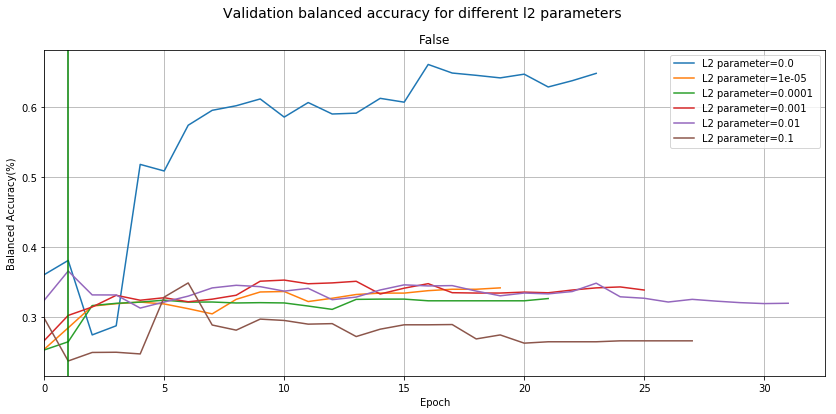

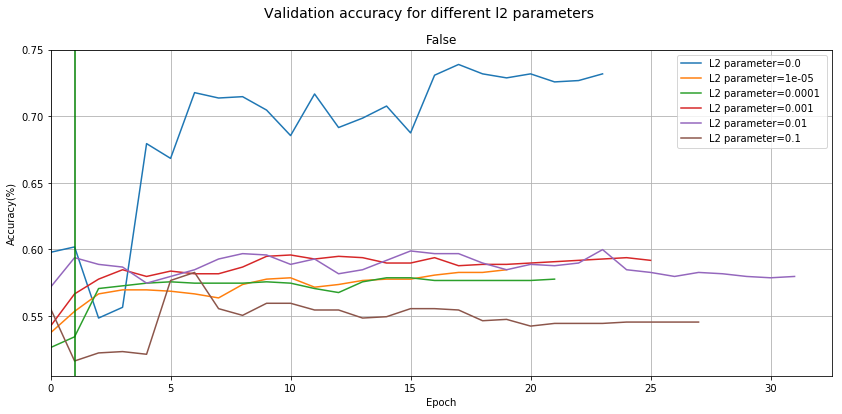

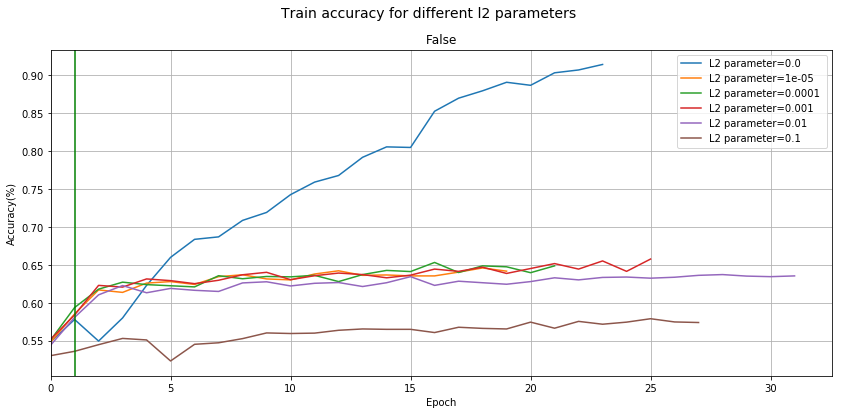

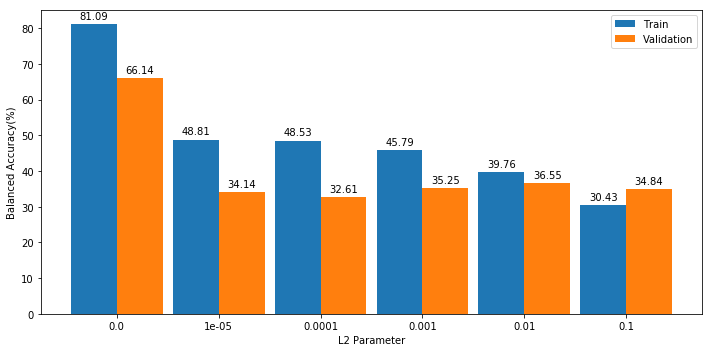

In [176]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "feepochs": 2, 
    "felr": 0.001, 
    "ftlr": 0.0001, 
    "batch": 16,
    "dropout": None,
    "dggroup": "11",
}

fig1 = plot_hyperparameter_over_epochs(
    models_info,
    "val_balanced_accuracy",
    "Balanced Accuracy(%)",
    hyperparameter_compared="lambda",
    hyperparameter_compared_label="L2 parameter",
    constant_parameters=constant_params,
    title="Validation balanced accuracy for different l2 parameters",
    feature_extract_epochs=2,
)

fig2 = plot_hyperparameter_over_epochs(
    models_info,
    "val_accuracy",
    "Accuracy(%)",
    hyperparameter_compared="lambda",
    hyperparameter_compared_label="L2 parameter",
    constant_parameters=constant_params,
    title="Validation accuracy for different l2 parameters",
    feature_extract_epochs=2,
)

fig3 = plot_hyperparameter_over_epochs(
    models_info,
    "accuracy",
    "Accuracy(%)",
    hyperparameter_compared="lambda",
    hyperparameter_compared_label="L2 parameter",
    constant_parameters=constant_params,
    title="Train accuracy for different l2 parameters",
    feature_extract_epochs=2,
)

fig5 = plot_hyperparameter_comparisson(
    filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ),
    "lambda",
    parameter_label="L2 Parameter",
    x_scale="log",
    bar_plot=True,
    figsize=(10,5)
)

fig5.savefig(os.path.join("densenet201_lambda_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

(0.0, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1)
(90.63, 37.37, 50.41, 51.96, 50.73, 46.9, 30.43)
(0.0, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1)
(92.52, 56.32, 65.6, 67.1, 66.57, 64.25, 54.52)


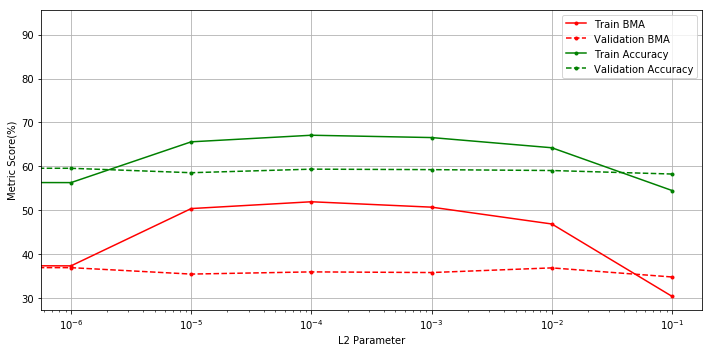

In [59]:
constant_params={
    "samples": 5000,
    "balanced": 0,
    "feepochs": 2, 
    "felr": 0.001, 
    "ftlr": 0.0001, 
    "batch": 16,
    "dropout": None,
    "dggroup": "11",
}

# fig1 = plot_hyperparameter_over_epochs(
#     models_info,
#     "val_balanced_accuracy",
#     "Balanced Accuracy(%)",
#     hyperparameter_compared="lambda",
#     hyperparameter_compared_label="L2 parameter",
#     constant_parameters=constant_params,
#     feature_extract_epochs=2,
# )

# fig2 = plot_hyperparameter_over_epochs(
#     models_info,
#     "val_accuracy",
#     "Accuracy(%)",
#     hyperparameter_compared="lambda",
#     hyperparameter_compared_label="L2 parameter",
#     constant_parameters=constant_params,
#     feature_extract_epochs=2,
# )

# fig3 = plot_hyperparameter_over_epochs(
#     models_info,
#     "accuracy",
#     "Accuracy(%)",
#     hyperparameter_compared="lambda",
#     hyperparameter_compared_label="L2 parameter",
#     constant_parameters=constant_params,
#     feature_extract_epochs=2,
# )

fig5 = plot_hyperparameter_comparisson(
    filter_models_info(
        models_info, 
        models=["DenseNet201"],
        parameters=constant_params
    ),
    "lambda",
    parameter_label="L2 Parameter",
    x_scale="log",
    figsize=(10,5)
)


## Test set results on dataset portion

Test data has 5067 samples.
'MEL':	904	(17.84%)
'NV':	2575	(50.82%)
'BCC':	665	(13.12%)
'AK':	173	(3.41%)
'BKL':	525	(10.36%)
'DF':	48	(0.95%)
'VASC':	51	(1.01%)
'SCC':	126	(2.49%)
'UNK':	0	(0.00%)


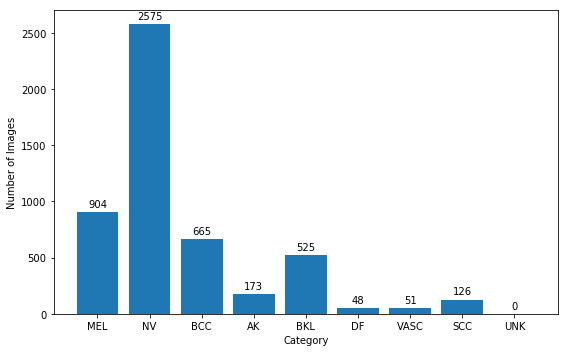

Model selection criteria: best_balanced_acc

Train + validation sampled: 5000
Feature extract epochs: 2
Feature extract learning rate: 0.001000
Fine tuning learning rate: 0.000100
Dropout rate: None
Batch size: 16
	accuracy:  0.7544898361949872
	balanced_accuracy_score:  0.5902073483747794


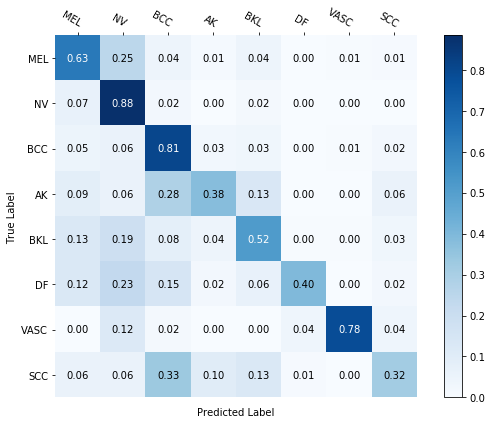

In [24]:
test_image_folder = os.path.join(data_folder, 'ISIC_2019_Test_Input')
test_ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Test_GroundTruth.csv')
df_test_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(
    test_image_folder, 
    test_ground_truth_file,
    test=True
)

known_category_num = len(known_category_names)
unknown_category_num = 1
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

count_per_category = Counter(df_test_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Test data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()
plt.show()

model_name = 'DenseNet201'
postfix = 'best_balanced_acc'
pred_test_folder = os.path.join("..", 'new_test_predict_results', model_name) 
print(f'Model selection criteria: {postfix}\n')

model_info = filter_models_info(
    models_info, 
    models=[model_name],
    parameters={
        "samples": 5000,
        "balanced": 0,
        "lambda": None,
        "feepochs": 2, 
        "felr": 0.001, 
        "ftlr": 0.0001, 
        "batch": 16,
        "dropout": None
    }
)[0]

print(f"Train + validation sampled: {model_info['hyperparameters']['samples']}")
print(f"Feature extract epochs: {model_info['hyperparameters']['feepochs']}")
print(f"Feature extract learning rate: {model_info['hyperparameters']['felr']}")
print(f"Fine tuning learning rate: {model_info['hyperparameters']['ftlr']}")
print(f"Dropout rate: {model_info['hyperparameters']['dropout']}")
print(f"Batch size: {model_info['hyperparameters']['batch']}")

# Load predicted results
df_pred = pd.read_csv(os.path.join(model_info["pred_test"], "no_unknown", f"{postfix}.csv"))
df = pd.merge(df_pred, df_test_ground_truth, on='image')
y_true = df['category']
y_pred = df['pred_category']
df.to_csv("test.csv")

# Compute Balanced Accuracy
print('\taccuracy: ', accuracy_score(y_true, y_pred))
print('\tbalanced_accuracy_score: ', balanced_accuracy_score(y_true, y_pred))

# Confusion Matrix
fig = plot_confusion_matrix(
    y_true, 
    y_pred, 
    known_category_names, 
    normalize=True,
    figsize=(8, 6)
)

fig.savefig(os.path.join("densenet201_5000_tuned_conf_matrix.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

In [81]:
data_folder = '../data/isic2019'
training_image_folder = os.path.join(data_folder, 'ISIC_2019_Training_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Training_GroundTruth.csv')

fig = plot_model_comparisson_balanced_acc(
    models_info, 
    load_isic_training_data(training_image_folder, ground_truth_file)[0],
    models=["DenseNet121", "DenseNet169", "DenseNet201"],
    constant_parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "2",
        "ftepochs": "100",
        "felr": "0.001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 16,
        "dggroup": "11"
    },
    figsize = (18,8)
)

fig2 = plot_model_comparisson_balanced_acc(
    models_info, 
    load_isic_training_data(training_image_folder, ground_truth_file)[0],
    models=["DenseNet121", "DenseNet169", "DenseNet201"],
    constant_parameters= {
        "balanced": "0",
        "samples": "20264",
        "feepochs": "2",
        "ftepochs": "100",
        "felr": "0.001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 16,
        "dggroup": "11"
    },
    figsize = (18,8)
)

# fig.savefig(os.path.join("densenet_variations_5000_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
# fig2.savefig(os.path.join("densenet_variations_20264_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

[{'model': 'DenseNet201', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '2', 'ftepochs': '100', 'felr': '0.001000', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '16', 'dggroup': '11'}, 'log': '../history/DenseNet201/balanced_0-samples_5000-feepochs_2-ftepochs_100-felr_0.001000-ftlr_0.000100-lambda_None-dropout_None-batch_16-dggroup_11/0/training.csv', 'pred_test_0': '../test_predict_results/DenseNet201/balanced_0-samples_5000-feepochs_2-ftepochs_100-felr_0.001000-ftlr_0.000100-lambda_None-dropout_None-batch_16-dggroup_11/0', 'pred_test': '../test_predict_results/DenseNet201/balanced_0-samples_5000-feepochs_2-ftepochs_100-felr_0.001000-ftlr_0.000100-lambda_None-dropout_None-batch_16-dggroup_11'}, {'model': 'DenseNet121', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '2', 'ftepochs': '100', 'felr': '0.001000', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '16', 'dggroup': '11'}, 'log': '../history/DenseN

FileNotFoundError: [Errno 2] File ../test_predict_results/DenseNet121/balanced_0-samples_5000-feepochs_2-ftepochs_100-felr_0.001000-ftlr_0.000100-lambda_None-dropout_None-batch_16-dggroup_11/no_unknown/best_balanced_acc.csv does not exist: '../test_predict_results/DenseNet121/balanced_0-samples_5000-feepochs_2-ftepochs_100-felr_0.001000-ftlr_0.000100-lambda_None-dropout_None-batch_16-dggroup_11/no_unknown/best_balanced_acc.csv'

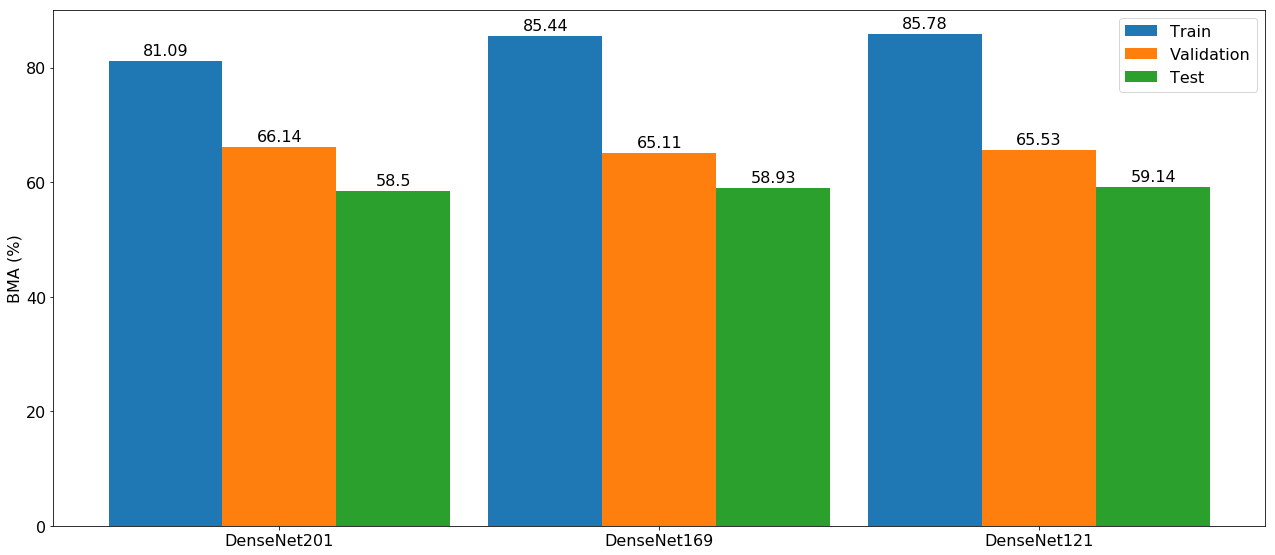

In [66]:
# Use some kind of benchmark hyperparameters in order to compare the models
figsize = (18,8)  

import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

xticklabels = ["DenseNet201", "DenseNet169", "DenseNet121"]
scalars0 = [81.09, 85.44, 85.78]
scalars1 = [66.14, 65.11, 65.53]
scalars2 = [58.5, 58.93, 59.14]

scalars2, scalars1, scalars0, xticklabels = zip(*sorted(zip(scalars2, scalars1, scalars0, xticklabels)))

x = np.arange(len(xticklabels))  # the label locations
width = 0.30  # the width of the bars

# Create grouped bar chart
fig, ax = plt.subplots(figsize=figsize)
fig.patch.set_facecolor('white')

rects0 = ax.bar(x - width, scalars0, width, label="Train")
rects1 = ax.bar(x, scalars1, width, label="Validation")
rects2 = ax.bar(x + width, scalars2, width, label="Test")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x)
ax.set_xticklabels(xticklabels)
ax.set(xlabel="", ylabel="BMA (%)")
ax.legend()
autolabel(ax, rects0)
autolabel(ax, rects1)
autolabel(ax, rects2)
fig.tight_layout()

fig.savefig(os.path.join("densenet_variations_5000_comp_2.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

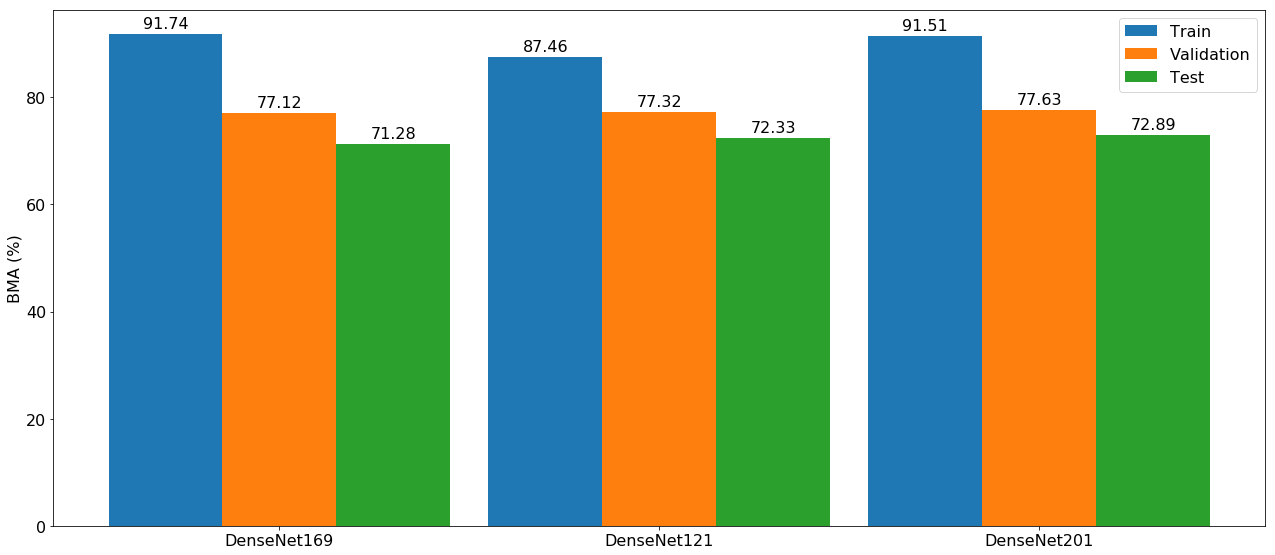

In [67]:
# Use some kind of benchmark hyperparameters in order to compare the models
figsize = (18,8)  

xticklabels = ["DenseNet169", "DenseNet121", "DenseNet201"]
scalars0 = [91.74, 87.46, 91.51]
scalars1 = [77.12, 77.32, 77.63]
scalars2 = [71.28, 72.33, 72.89]

scalars2, scalars1, scalars0, xticklabels = zip(*sorted(zip(scalars2, scalars1, scalars0, xticklabels)))

x = np.arange(len(xticklabels))  # the label locations
width = 0.30  # the width of the bars

# Create grouped bar chart
fig, ax = plt.subplots(figsize=figsize)
fig.patch.set_facecolor('white')

rects0 = ax.bar(x - width, scalars0, width, label="Train")
rects1 = ax.bar(x, scalars1, width, label="Validation")
rects2 = ax.bar(x + width, scalars2, width, label="Test")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x)
ax.set_xticklabels(xticklabels)
ax.set(xlabel="", ylabel="BMA (%)")
ax.legend()
autolabel(ax, rects0)
autolabel(ax, rects1)
autolabel(ax, rects2)
fig.tight_layout()

fig.savefig(os.path.join("densenet_variations_20264_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

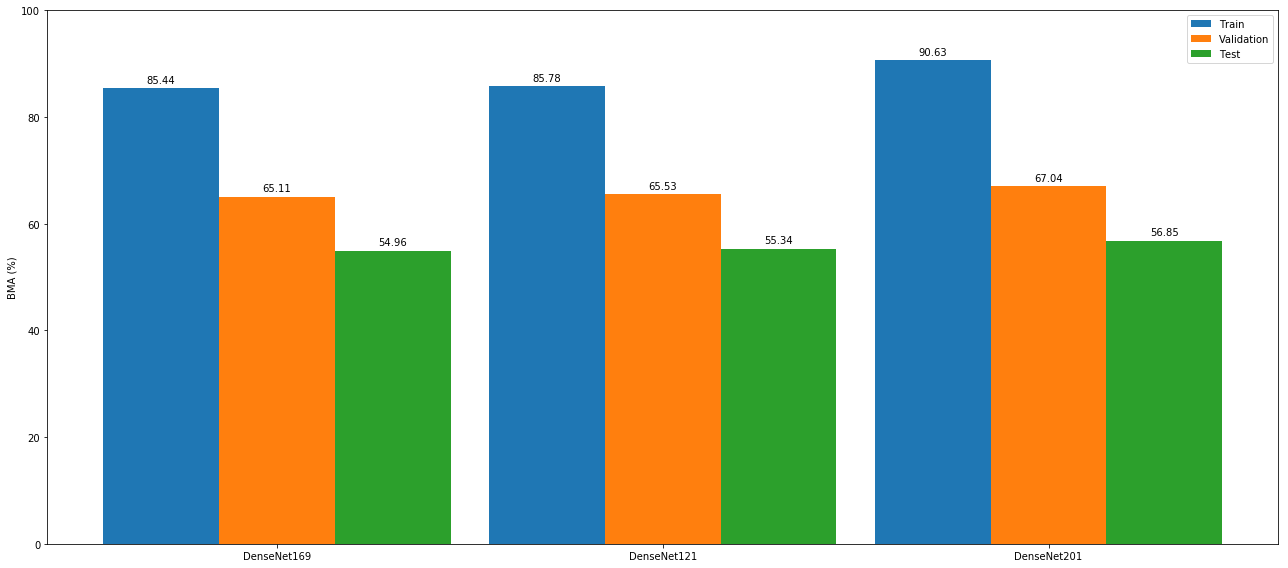

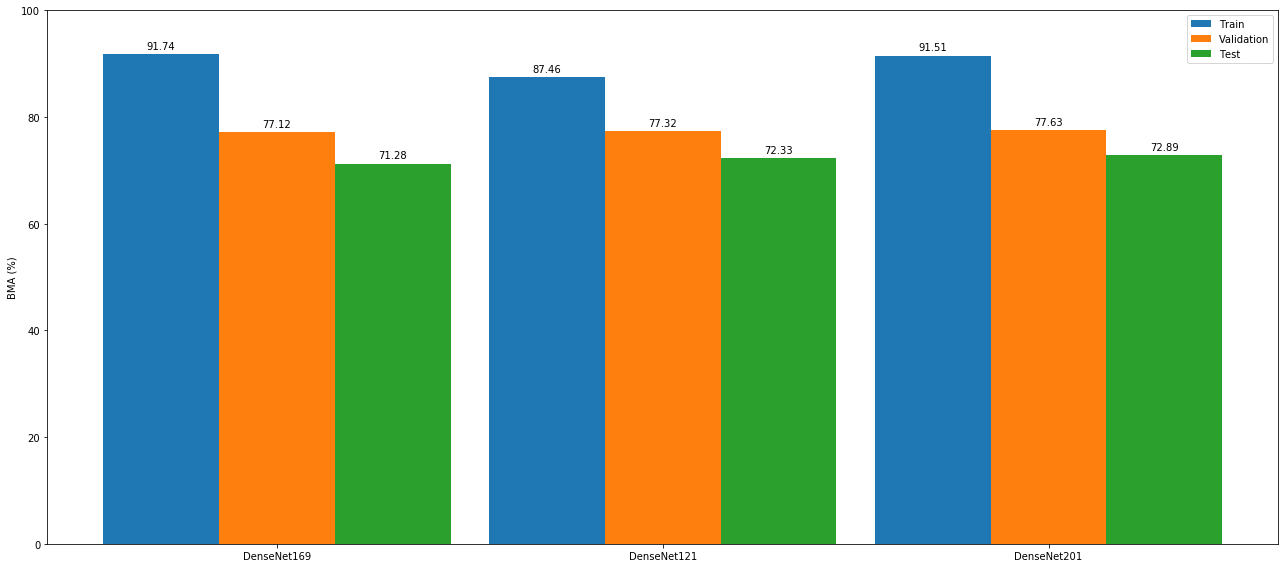

In [56]:
data_folder = '../data/isic2019/sampled_unbalanced_5000'
training_image_folder = os.path.join(data_folder, 'ISIC_2019_Test_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Test_GroundTruth.csv')

# fig = plot_model_comparisson_balanced_acc(
#     models_info, 
#     load_isic_training_data(training_image_folder, ground_truth_file)[0],
#     models=["DenseNet121", "DenseNet169", "DenseNet201"],
#     constant_parameters= {
#         "balanced": "0",
#         "samples": "5000",
#         "feepochs": "2",
#         "ftepochs": "100",
#         "felr": "0.001",
#         "ftlr": "0.0001",
#         "lambda": None,
#         "dropout": None,
#         "batch": 16,
#         "dggroup": "11"
#     },
#     figsize = (18,8)
# )

fig2 = plot_model_comparisson_balanced_acc(
    models_info, 
    load_isic_training_data(training_image_folder, ground_truth_file)[0],
    models=["DenseNet121", "DenseNet169", "DenseNet201"],
    constant_parameters= {
        "balanced": "0",
        "samples": "20264",
        "feepochs": "2",
        "ftepochs": "100",
        "felr": "0.001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 16,
        "dggroup": "11"
    },
    figsize = (18,8)
)


Test data has 5067 samples.
'MEL':	904	(17.84%)
'NV':	2575	(50.82%)
'BCC':	665	(13.12%)
'AK':	173	(3.41%)
'BKL':	525	(10.36%)
'DF':	48	(0.95%)
'VASC':	51	(1.01%)
'SCC':	126	(2.49%)
'UNK':	0	(0.00%)


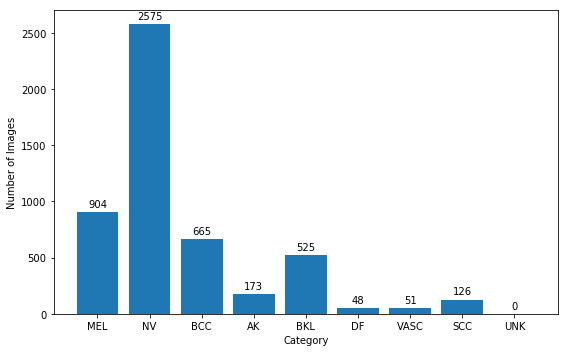

Model selection criteria: best_balanced_acc

Train + validation sampled: 5000
Feature extract epochs: 2
Feature extract learning rate: 0.001000
Fine tuning learning rate: 0.000100
Dropout rate: None
Batch size: 16
	accuracy:  0.7422537990921649
	balanced_accuracy_score:  0.5685294360924568


In [57]:
test_image_folder = os.path.join(data_folder, 'ISIC_2019_Test_Input')
test_ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Test_GroundTruth.csv')
df_test_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(
    test_image_folder, 
    test_ground_truth_file,
    test=True
)

known_category_num = len(known_category_names)
unknown_category_num = 1
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

count_per_category = Counter(df_test_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Test data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()
plt.show()

model_name = 'DenseNet201'
postfix = 'best_balanced_acc'
pred_test_folder = os.path.join("..", 'new_test_predict_results', model_name) 
print(f'Model selection criteria: {postfix}\n')

model_info = filter_models_info(
    models_info, 
    models=[model_name],
    parameters={
        "samples": 5000,
        "balanced": 0,
        "lambda": None,
        "feepochs": 2, 
        "felr": 0.001, 
        "ftlr": 0.0001, 
        "batch": 16,
        "dropout": None
    }
)[0]

print(f"Train + validation sampled: {model_info['hyperparameters']['samples']}")
print(f"Feature extract epochs: {model_info['hyperparameters']['feepochs']}")
print(f"Feature extract learning rate: {model_info['hyperparameters']['felr']}")
print(f"Fine tuning learning rate: {model_info['hyperparameters']['ftlr']}")
print(f"Dropout rate: {model_info['hyperparameters']['dropout']}")
print(f"Batch size: {model_info['hyperparameters']['batch']}")

# Load predicted results
df_pred = pd.read_csv(os.path.join(model_info["pred_test"], "no_unknown", f"{postfix}.csv"))
df = pd.merge(df_pred, df_test_ground_truth, on='image')
y_true = df['category']
y_pred = df['pred_category']
df.to_csv("test.csv")

# Compute Balanced Accuracy
print('\taccuracy: ', accuracy_score(y_true, y_pred))
print('\tbalanced_accuracy_score: ', balanced_accuracy_score(y_true, y_pred))